In [1]:
# Data handling and processing
import pandas as pd
import numpy as np
import random
import os 
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Model evaluation and utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', message="is_sparse is deprecated")
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import roc_auc_score, brier_score_loss

# XGBoost
import xgboost as xgb
print(xgb.__version__)

# Statsmodels
import statsmodels.api as sm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchmetrics
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss

# Optuna for hyperparameter optimization
import optuna
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import log_loss
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init

2.1.1


### Prepare NN input

In [2]:
def process_sample(sample):
    # Define the paths based on the sample name
    qb_path = f'/data2/1000Genome/{sample}/qb/{sample}'
    readcount_path = f'/data2/1000Genome/{sample}/beastie/runModel_phased_even100/chr1-22_alignBiasp0.05_s0.7_a0.05_sinCov0_totCov1_W1000K1000/tmp/{sample}'
    
    # Check if the 'beastie' folder exists (we already filtered for this, so this is optional now)
    if not os.path.isdir(f'/data2/1000Genome/{sample}/beastie'):
        return

    # Read the qb file and extract qb_label
    qb_data = pd.read_csv(f"{qb_path}_qb_highestsite.tsv", sep='\t')
    qb_data["qb_label"] = qb_data["qb_mode"]
    qb_label = qb_data[["geneID", "qb_label"]]

    # Read the input readcount file
    input_readcount = pd.read_csv(f"{readcount_path}_real_alignBiasafterFilter.phasedByshapeit2.cleaned.tsv", sep='\t')
    input_readcount = input_readcount[["geneID", "chrN", "pos", "refCount", "altCount"]]

    # Read the genetic features file
    genetic_features = pd.read_csv(f"{readcount_path}.meta.w_error.tsv", sep='\t')
    genetic_features = genetic_features[["geneID", "pos", "MAF", "min_MAF", "diff_MAF", "d", "r2", "log10_distance"]]

    # Perform inner join of the genetic features and the input readcount
    input_df = pd.merge(input_readcount, genetic_features, how="inner", on=["geneID", "pos"])
    input_df["individual"] = sample

    # Read the ancestry file and get the first word
    ancestry_file = f'/data2/1000Genome/{sample}/ancestry'
    with open(ancestry_file, 'r') as file:
        ancestry = file.readline().strip()

    input_df["ancestry"] = ancestry

    # Format the geneID column
    input_df["geneID"] = input_df["geneID"].str.split(".").str[0]

    # Merge input_df with qb_label
    input_df = pd.merge(input_df, qb_label, how="inner", on=["geneID"])

    # Save the final DataFrame as a TSV file
    output_file = f"{qb_path}_NN_input.tsv"
    input_df.to_csv(output_file, sep='\t', index=False)


In [3]:
# # Find only the samples with the 'beastie' directory
# base_dir = '/data2/1000Genome/'
# samples = [
#     sample for sample in os.listdir(base_dir)
#     if os.path.isdir(os.path.join(base_dir, sample)) and
#     os.path.isdir(f'/data2/1000Genome/{sample}/beastie')
# ]

# # Process each sample with a progress bar
# for sample in tqdm(samples, desc="Processing samples"):
#     process_sample(sample)

### Randomly select some individuals for a training set and testing set

In [3]:
def select_and_split_samples(ancestry_groups, num_individuals_train=80, num_individuals_test=20, base_dir='/data2/1000Genome/'):
    # Ensure ancestry_groups is a list
    if isinstance(ancestry_groups, str):
        ancestry_groups = [ancestry_groups]
    
    # Calculate per-group requirements
    num_groups = len(ancestry_groups)
    num_train_per_group = num_individuals_train // num_groups
    num_test_per_group = num_individuals_test // num_groups
    
    # Validate that the train and test counts are evenly divisible
    if num_individuals_train % num_groups != 0 or num_individuals_test % num_groups != 0:
        raise ValueError("Train and test counts must be evenly divisible by the number of ancestry groups.")
    
    # Collect output file paths for each ancestry group
    ancestry_files = {group: [] for group in ancestry_groups}
    for sample in os.listdir(base_dir):
        sample_dir = os.path.join(base_dir, sample)
        ancestry_file = os.path.join(sample_dir, 'ancestry')
        output_file = os.path.join(sample_dir, 'qb', f"{sample}_NN_input.tsv")
        
        # Check if both ancestry file and output file exist
        if os.path.isfile(ancestry_file) and os.path.isfile(output_file):
            with open(ancestry_file, 'r') as file:
                ancestry = file.readline().strip()
            # Collect the file path if it matches any specified ancestry group
            if ancestry in ancestry_files:
                ancestry_files[ancestry].append(output_file)
    
    # Initialize empty lists for train and test files
    train_files = []
    test_files = []
    
    # Check and select files for each ancestry group
    for group, files in ancestry_files.items():
        if len(files) < (num_train_per_group + num_test_per_group):
            raise ValueError(f"Not enough individuals in {group} ancestry group. Required: {num_train_per_group + num_test_per_group}, Found: {len(files)}")
        
        # Randomly select individuals for train and test
        selected_files = random.sample(files, num_train_per_group + num_test_per_group)
        train_files.extend(selected_files[:num_train_per_group])
        test_files.extend(selected_files[num_train_per_group:num_train_per_group + num_test_per_group])
    
    # Combine data for the training set
    train_df = pd.DataFrame()
    for file_path in train_files:
        df = pd.read_csv(file_path, sep='\t')
        train_df = pd.concat([train_df, df], ignore_index=True)
    
    # Combine data for the test set
    test_df = pd.DataFrame()
    for file_path in test_files:
        df = pd.read_csv(file_path, sep='\t')
        test_df = pd.concat([test_df, df], ignore_index=True)
    
    return train_df, test_df

In [4]:
# Example usage
train_df, test_df = select_and_split_samples(['GBR', 'CEU', 'TSI', 'YRI'], num_individuals_train=80, num_individuals_test=20)

In [5]:
train_df.head()

,geneID,chrN,pos,refCount,altCount,MAF,min_MAF,diff_MAF,d,r2,log10_distance,individual,ancestry,qb_label
0,ENSG00000177757,1,754182,2,1,0.1282,NaN,NaN,NaN,NaN,NaN,HG00234,GBR,0.475200
1,ENSG00000177757,1,754503,1,0,0.1610,0.1282,0.0328,1.0,0.868,2.506505,HG00234,GBR,0.475200
2,ENSG00000177757,1,754964,0,1,0.1630,0.1610,0.0020,1.0,1.000,2.663701,HG00234,GBR,0.475200
3,ENSG00000225880,1,762601,4,3,0.1282,0.1282,0.0348,NaN,NaN,NaN,HG00234,GBR,0.477750
4,ENSG00000187634,1,879317,0,1,0.0398,0.0398,0.0884,NaN,NaN,NaN,HG00234,GBR,0.530147


In [6]:
test_df.head()

,geneID,chrN,pos,refCount,altCount,MAF,min_MAF,diff_MAF,d,r2,log10_distance,individual,ancestry,qb_label
0,ENSG00000188976,1,881627,60,45,0.3668,NaN,NaN,NaN,NaN,NaN,HG00232,GBR,0.438744
1,ENSG00000188976,1,882033,1,1,0.2495,0.2495,0.1173,1.000,0.655,2.608526,HG00232,GBR,0.438744
2,ENSG00000187961,1,900505,7,8,0.2903,0.2495,0.0408,NaN,NaN,NaN,HG00232,GBR,0.516317
3,ENSG00000187583,1,909309,0,3,0.1839,0.1839,0.1064,NaN,NaN,NaN,HG00232,GBR,0.591080
4,ENSG00000187583,1,910394,1,1,0.3211,0.1839,0.1372,0.652,0.171,3.035430,HG00232,GBR,0.591080


### modify the testset

In [159]:
def prepare_data_for_cnn_individual(data, feature_columns, label_col='qb_label'):
    # Step 1: Determine the maximum number of hets per gene across individuals
    max_hets_per_gene = data.groupby(['individual', 'geneID']).size().max()
    
    # Step 2: Calculate relative position for each gene by individual
    # Sort by geneID and position for proper ordering
    data = data.sort_values(by=['individual', 'geneID', 'pos'])
    #data['relative_pos'] = data.groupby(['individual', 'geneID'])['pos'].diff().fillna(0)
    data['log10_distance'] = data['log10_distance'].fillna(0)
    # fill in d' values with 0.5 if nan
    data['d'] = data['d'].fillna(0.5)
    # fill in r2 values with 0.2-0.3 uniform distribution if nan
    data['r2'] = data['r2'].fillna(np.random.uniform(0.2, 0.3))
    # fill in NAn with 0 for min_MAF
    data['min_MAF'] = data['min_MAF'].fillna(0)
    # fill in NAn with 0 for diff_MAF
    data['diff_MAF'] = data['diff_MAF'].fillna(0)
    
    # Step 3: Filter relevant columns - dropping geneID, chrN, and pos
    X_data = []
    y_data = []
    
    # Group by individual and geneID to form CNN inputs
    grouped = data.groupby(['individual', 'geneID'])
    
    for (individual, geneID), group in grouped:
        # Extract the feature columns for the current individual and gene
        X = group[feature_columns].to_numpy()
        
        # Pad the feature array to have the same number of rows
        padded_X = np.zeros((max_hets_per_gene, len(feature_columns)))
        padded_X[:X.shape[0], :] = X  # Fill in the available data
        
        # Get the label (assumes it's the same across all rows in the group)
        y = group[label_col].iloc[0]
        
        # Append to the lists
        X_data.append(padded_X)
        y_data.append(y)
    
    # Convert the lists to numpy arrays suitable for CNN input
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

In [160]:
data_train = train_df
feature_columns = ['refCount', 'altCount', 'MAF', 'min_MAF', 'diff_MAF', 'log10_distance', 'd', 'r2']
X_train, y_train = prepare_data_for_cnn_individual(data_train, feature_columns)
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)


X shape: (589222, 62, 8)
y shape: (589222,)


In [161]:
data_test = test_df
X_test, y_test = prepare_data_for_cnn_individual(data_test, feature_columns)
print("X test shape:", X_test.shape)
print("y test shape:", y_test.shape)

X test shape: (149173, 62, 8)
y test shape: (149173,)


In [162]:
train_df.head()

,geneID,chrN,pos,refCount,altCount,MAF,min_MAF,diff_MAF,d,r2,log10_distance,individual,ancestry,qb_label
0,ENSG00000188976,1,881627,93,67,0.3668,NaN,NaN,NaN,NaN,NaN,HG00261,GBR,0.431798
1,ENSG00000188976,1,889876,7,3,0.0159,0.0159,0.3509,1.0,0.027,3.916401,HG00261,GBR,0.431798
2,ENSG00000187961,1,896064,0,1,0.0378,0.0159,0.0219,NaN,NaN,NaN,HG00261,GBR,0.313768
3,ENSG00000187961,1,897730,11,2,0.0388,0.0378,0.0010,1.0,1.000,3.221675,HG00261,GBR,0.313768
4,ENSG00000187961,1,900741,9,3,0.0010,0.0010,0.0378,1.0,0.000,3.478711,HG00261,GBR,0.313768


### CNN

In [163]:
class GeneCNN(nn.Module):
    def __init__(self, input_features):
        super(GeneCNN, self).__init__()
        
        # Convolutional and pooling layers
        ## the number of filters in the 1st conv layer is 32 (common choice 16-64)
        self.conv1 = nn.Conv1d(in_channels = input_features, out_channels=32, kernel_size=2)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        ## the number of filters in the 2nd conv layer is 32 (common choice 16-64)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        ## the number of filters in the 3rd conv layer is 64 (common choice 16-64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2)
        
        # Adaptive pooling layer to reduce size to 1
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 64)  # Adjusted input size to match the output channels from global_pool
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 1)  # Single output neuron for regression
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

        # # Add two batch normalization layers
        # self.bn1 = nn.BatchNorm1d(128)
        # self.bn2 = nn.BatchNorm1d(8)

        # # Apply He initialization
        # init.kaiming_uniform_(self.fc1.weight)
        # init.kaiming_uniform_(self.fc2.weight)
        # init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    def forward(self, x):
        # Transpose to match Conv1d input format: (batch_size, features, length)
        x = x.transpose(1, 2)
        
        # Convolution and pooling layers
        x = self.pool1(F.relu(self.conv1(x)))  # Conv1 and pooling
        #print(f"Shape after conv1 and pool1: {x.shape}")
        
        x = self.pool2(F.relu(self.conv2(x)))  # Conv2 and pooling
        #print(f"Shape after conv2 and pool2: {x.shape}")
        
        x = F.relu(self.conv3(x))              # Conv3
        #print(f"Shape after conv3: {x.shape}")
        
        x = self.global_pool(x)                # Adaptive pooling to size 1
        #print(f"Shape after global_pool: {x.shape}")
        
        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)              # Flatten
        #print(f"Shape after flattening: {x.shape}")
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        # Output layer for regression (no activation or add sigmoid if bounded)
        x = self.fc3(x)
        
        return x



In [164]:
X_train.shape[2]

8

In [165]:
# Instantiate the model, loss function, and optimizer
max_hets_per_gene = X_train.shape[2]  # Use the maximum number of hets per gene
model = GeneCNN(input_features = max_hets_per_gene) # 6 features

# Model summary
print(model)

GeneCNN(
  (conv1): Conv1d(8, 32, kernel_size=(2,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(2,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(2,), stride=(1,))
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [166]:
# Assuming X_train and y_train are initially your full training data
# Set aside a portion for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)

# Convert them to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [167]:
# Create a dataset and a DataLoader with a smaller batch size
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Adjust batch size as needed
val_loader = DataLoader(val_dataset, batch_size=128)

In [168]:
# Check for NaNs or Infs in input and target data
print("NaNs in X_train:", torch.isnan(X_train).any())
print("NaNs in y_train:", torch.isnan(y_train).any())
print("Infs in X_train:", torch.isinf(X_train).any())
print("Infs in y_train:", torch.isinf(y_train).any())

print("NaNs in X_val:", torch.isnan(X_val).any())
print("NaNs in y_val:", torch.isnan(y_val).any())
print("Infs in X_val:", torch.isinf(X_val).any())
print("Infs in y_val:", torch.isinf(y_val).any())


NaNs in X_train: tensor(False)
NaNs in y_train: tensor(False)
Infs in X_train: tensor(False)
Infs in y_train: tensor(False)
NaNs in X_val: tensor(False)
NaNs in y_val: tensor(False)
Infs in X_val: tensor(False)
Infs in y_val: tensor(False)


In [169]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = GeneCNN(input_features=max_hets_per_gene).to(device)  # Change input_features to the correct feature count

# Define loss function, optimizer, and optional scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss_epoch = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_batch)
        train_mse_loss = criterion(outputs, y_batch)  # MSE Loss
        train_rmse_loss = torch.sqrt(train_mse_loss)  # RMSE
        
        # Backward pass
        train_mse_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss_epoch += train_mse_loss.item()  # Accumulate MSE loss
    
    # Validation
    model.eval()
    val_loss_epoch = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = model(X_val_batch)
            val_mse_loss = criterion(val_outputs, y_val_batch)
            val_loss_epoch += val_mse_loss.item()  # Accumulate MSE loss

    # Calculate average RMSE for the epoch
    avg_train_rmse = torch.sqrt(torch.tensor(train_loss_epoch / len(train_loader))).item()
    avg_val_rmse = torch.sqrt(torch.tensor(val_loss_epoch / len(val_loader))).item()

    # Store the RMSE losses for each epoch
    train_losses.append(avg_train_rmse)
    val_losses.append(avg_val_rmse)
    
    # Step the scheduler based on validation loss
    scheduler.step(avg_val_rmse)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train RMSE: {avg_train_rmse:.4f}, Validation RMSE: {avg_val_rmse:.4f}")


/home/scarlett/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train RMSE: 0.0872, Validation RMSE: 0.0494
Epoch [2/100], Train RMSE: 0.0517, Validation RMSE: 0.0457
Epoch [3/100], Train RMSE: 0.0494, Validation RMSE: 0.0442
Epoch [4/100], Train RMSE: 0.0461, Validation RMSE: 0.0444
Epoch [5/100], Train RMSE: 0.0453, Validation RMSE: 0.0425
Epoch [6/100], Train RMSE: 0.0447, Validation RMSE: 0.0433
Epoch [7/100], Train RMSE: 0.0438, Validation RMSE: 0.0417
Epoch [8/100], Train RMSE: 0.0435, Validation RMSE: 0.0414
Epoch [9/100], Train RMSE: 0.0431, Validation RMSE: 0.0416
Epoch [10/100], Train RMSE: 0.0427, Validation RMSE: 0.0415
Epoch [11/100], Train RMSE: 0.0423, Validation RMSE: 0.0426
Epoch [12/100], Train RMSE: 0.0421, Validation RMSE: 0.0418
Epoch [13/100], Train RMSE: 0.0413, Validation RMSE: 0.0416
Epoch [14/100], Train RMSE: 0.0413, Validation RMSE: 0.0416
Epoch [15/100], Train RMSE: 0.0412, Validation RMSE: 0.0410
Epoch [16/100], Train RMSE: 0.0410, Validation RMSE: 0.0418
Epoch [17/100], Train RMSE: 0.0410, Validation RM

#### RELU

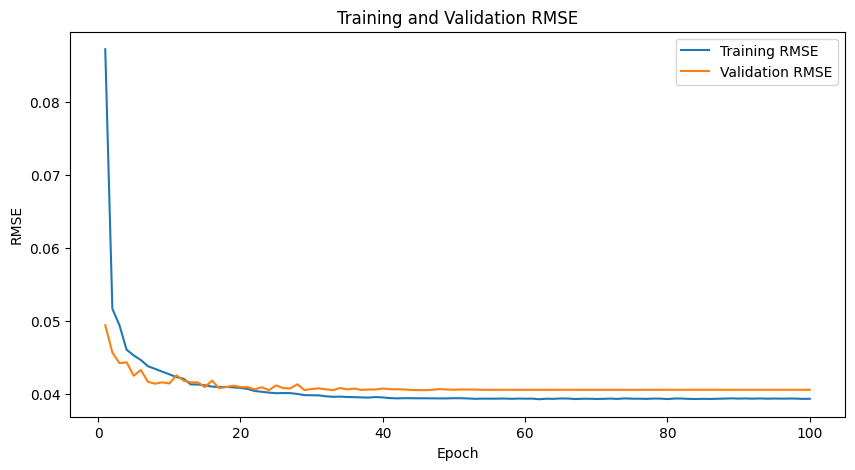

In [170]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training RMSE')
plt.plot(range(1, epochs + 1), val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

In [178]:
# Create a DataLoader for the test set with a smaller batch size
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64)  # Adjust batch size as needed

# Final evaluation on test set
model.eval()
test_loss_total = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        test_outputs = model(X_batch)
        test_loss = criterion(test_outputs, y_batch)  # MSE Loss
        test_loss_total += test_loss.item() * X_batch.size(0)  # Sum up the batch loss (weighted by batch size)

# Calculate the average loss and take the square root for RMSE
average_test_mse = test_loss_total / len(test_loader.dataset)
average_test_rmse = torch.sqrt(torch.tensor(average_test_mse)).item()
print(f"Final Test RMSE: {average_test_rmse:.4f}")

Final Test RMSE: 0.0416


## Simulator

In [179]:
def simulate_reads_single_gene(p=0.5, read_coverage=100, phasing_error=0.04, num_hets=10, max_hets=64, data=None):
    np.random.seed(42)  # For reproducibility

    # Initialize lists to store simulated data
    ref_counts = []
    alt_counts = []
    switches = []

    # Sample MAF and log10_distance for each het site
    if data is None:
        raise ValueError("MAF and log10_distance data must be provided.")
    

    # Sample MAF and log10_distance for each het site in the gene
    samples = data.sample(n=num_hets, replace=True)
    # fill in missing data
    samples['log10_distance'] = samples['log10_distance'].fillna(0)
    # fill in d' values with 0.5 if nan
    samples['d'] = samples['d'].fillna(0.5)
    # fill in r2 values with 0.2-0.3 uniform distribution if nan
    samples['r2'] = samples['r2'].fillna(np.random.uniform(0.2, 0.3))
    # fill in NAn with 0 for min_MAF
    samples['min_MAF'] = samples['min_MAF'].fillna(0)
    # fill in NAn with 0 for diff_MAF
    samples['diff_MAF'] = samples['diff_MAF'].fillna(0)

    maf_values = samples['MAF'].values
    min_maf_values = samples['min_MAF'].values
    diff_maf_values = samples['diff_MAF'].values
    log10_distance_values = samples['log10_distance'].values
    d_values = samples['d'].values
    r2_values = samples['r2'].values

    # Convert log10_distance to distance and handle NaN by replacing with mean distance
    #distance_values = np.where(~np.isnan(log10_distance_values), 10**log10_distance_values, np.nan)
    #mean_distance = np.nanmean(distance_values)
    #distance_values = np.where(np.isnan(distance_values), mean_distance, distance_values)

    current_phase = False  # Start without phase flipping

    # Loop over each heterozygous site
    for het in range(num_hets):
        # Simulate binomial read counts based on the binomial probability
        ref_count = np.random.binomial(n=read_coverage, p=p)  # Total ref count for this het
        alt_count = read_coverage - ref_count  # Total alt count for this het

        # Generate a random phasing error to determine if a phase switch occurs
        phase_switch = np.random.rand() < phasing_error
        
        # If a phasing error occurred, toggle the current phase
        if phase_switch:
            current_phase = not current_phase

        # If current phase is switched, swap the ref and alt counts
        if current_phase:
            ref_count, alt_count = alt_count, ref_count
            switches.append(1)  # Indicate a switch
        else:
            switches.append(0)  # No switch

        # Store accumulated values for this het site
        ref_counts.append(ref_count)
        alt_counts.append(alt_count)
        # mafs.append(maf_values[het])

    # feature_columns = ['refCount', 'altCount', 'MAF', 'min_MAF', 'diff_MAF', 'log10_distance', 'd', 'r2']
    # Create DataFrame for model input with the four features
    data = {
        'refCount': ref_counts,
        'altCount': alt_counts,
        'MAF': maf_values,
        'min_MAF': min_maf_values,
        'diff_MAF': diff_maf_values,
        'log10_distance': log10_distance_values,
        'd': d_values,
        'r2': r2_values,
        'switch': switches
    }
    df_input = pd.DataFrame(data)
    
    # Pad the DataFrame to have max_hets rows
    padded_data = np.zeros((max_hets, len(df_input.columns) - 1))  # Exclude the 'switch' column from padding
    padded_data[:df_input.shape[0], :] = df_input.drop(columns=['switch']).values  # Fill in available data and zero-pad remaining rows
    
    # Convert padded data to numpy arrays similar to `prepare_data_for_cnn_individual` output
    X_data = np.array([padded_data])  # Add batch dimension to match the expected CNN input format
    y_data = np.array([p])  # Here, the `p` is used as a placeholder for the label
    
    return X_data, y_data, df_input  # Return DataFrame for visualization as well



def evaluate_simulation(X_sim, y_sim, model, device='cpu'):
    """
    Runs the model on simulated data, calculates the predicted binomial p values, 
    and returns the RMSE compared to the true p values.

    Parameters:
    - X_sim: np.array, simulated input features
    - y_sim: np.array, true binomial p values
    - model: PyTorch model, the trained model to use for predictions
    - device: str, device to run the model on ('cpu' or 'cuda')

    Returns:
    - predicted_p_values: np.array, the predicted binomial p values
    - rmse: float, root mean squared error between the predicted and true p values
    """

    # Convert X_sim and y_sim to PyTorch tensors
    X_sim_tensor = torch.tensor(X_sim, dtype=torch.float32).to(device)
    y_sim_tensor = torch.tensor(y_sim, dtype=torch.float32).unsqueeze(1).to(device)

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Run the model to get the predicted binomial p values
        predicted_p = model(X_sim_tensor)
        
        # Print the predicted binomial p values for inspection
        print("Predicted binomial p values:")
        print(predicted_p.cpu().numpy())
        
        # Calculate the Mean Squared Error (MSE)
        mse_loss = nn.MSELoss()(predicted_p, y_sim_tensor)
        
        # Calculate the RMSE
        rmse = torch.sqrt(mse_loss).item()
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    
    # Return the predicted p values and RMSE
    return predicted_p.cpu().numpy(), rmse


In [180]:
# Simulate data using the function
X_sim, y_sim, df_vis = simulate_reads_single_gene(
    p=0.5, read_coverage=20, phasing_error=0.04, num_hets=10, max_hets=64, data=train_df
)

# Call the evaluation function
predicted_p_values, rmse = evaluate_simulation(X_sim, y_sim, model, device)

# Visualize the simulated data if needed
df_vis

Predicted binomial p values:
[[0.5018013]]
Root Mean Squared Error (RMSE): 0.0018


,refCount,altCount,MAF,min_MAF,diff_MAF,log10_distance,d,r2,switch
0,7,13,0.2893,0.2893,0.0000,1.995635,1.000,1.000000,0
1,11,9,0.1203,0.1143,0.0060,2.107210,1.000,0.912000,0
2,5,15,0.0636,0.0636,0.0000,4.511456,1.000,1.000000,0
3,12,8,0.4652,0.1876,0.2776,0.000000,0.500,0.215599,0
4,8,12,0.4911,0.4583,0.0328,3.943890,1.000,0.876000,0
5,9,11,0.1256,0.1256,0.3388,3.283979,1.000,0.146000,0
6,10,10,0.4851,0.0895,0.3956,0.000000,0.500,0.215599,0
7,11,9,0.4205,0.0954,0.3251,0.000000,0.500,0.215599,0
8,9,11,0.3141,0.3131,0.0010,5.762318,0.705,0.433000,0
9,10,10,0.3062,0.2028,0.1034,0.000000,0.500,0.215599,0


In [181]:
# Simulate data using the function
X_sim, y_sim, df_vis = simulate_reads_single_gene(
    p=0.5, read_coverage=100, phasing_error=0.04, num_hets=10, max_hets=64, data=train_df
)

# Call the evaluation function
predicted_p_values, rmse = evaluate_simulation(X_sim, y_sim, model, device)

# Visualize the simulated data if needed
df_vis

Predicted binomial p values:
[[0.49537563]]
Root Mean Squared Error (RMSE): 0.0046


,refCount,altCount,MAF,min_MAF,diff_MAF,log10_distance,d,r2,switch
0,44,56,0.2893,0.2893,0.0000,1.995635,1.000,1.000000,0
1,52,48,0.1203,0.1143,0.0060,2.107210,1.000,0.912000,0
2,58,42,0.0636,0.0636,0.0000,4.511456,1.000,1.000000,0
3,51,49,0.4652,0.1876,0.2776,0.000000,0.500,0.215599,0
4,56,44,0.4911,0.4583,0.0328,3.943890,1.000,0.876000,0
5,50,50,0.1256,0.1256,0.3388,3.283979,1.000,0.146000,0
6,49,51,0.4851,0.0895,0.3956,0.000000,0.500,0.215599,0
7,46,54,0.4205,0.0954,0.3251,0.000000,0.500,0.215599,0
8,43,57,0.3141,0.3131,0.0010,5.762318,0.705,0.433000,0
9,57,43,0.3062,0.2028,0.1034,0.000000,0.500,0.215599,0


In [182]:
# Simulate data using the function
X_sim, y_sim, df_vis = simulate_reads_single_gene(
    p=0.1, read_coverage=100, phasing_error=0.04, num_hets=10, max_hets=64, data=train_df
)

# Call the evaluation function
predicted_p_values, rmse = evaluate_simulation(X_sim, y_sim, model, device)

# Visualize the simulated data if needed
df_vis

Predicted binomial p values:
[[0.9043281]]
Root Mean Squared Error (RMSE): 0.8043


,refCount,altCount,MAF,min_MAF,diff_MAF,log10_distance,d,r2,switch
0,6,94,0.2893,0.2893,0.0000,1.995635,1.000,1.000000,0
1,11,89,0.1203,0.1143,0.0060,2.107210,1.000,0.912000,0
2,4,96,0.0636,0.0636,0.0000,4.511456,1.000,1.000000,0
3,13,87,0.4652,0.1876,0.2776,0.000000,0.500,0.215599,0
4,7,93,0.4911,0.4583,0.0328,3.943890,1.000,0.876000,0
5,8,92,0.1256,0.1256,0.3388,3.283979,1.000,0.146000,0
6,9,91,0.4851,0.0895,0.3956,0.000000,0.500,0.215599,0
7,11,89,0.4205,0.0954,0.3251,0.000000,0.500,0.215599,0
8,8,92,0.3141,0.3131,0.0010,5.762318,0.705,0.433000,0
9,10,90,0.3062,0.2028,0.1034,0.000000,0.500,0.215599,0


In [1]:
# Simulate data using the function
X_sim, y_sim, df_vis = simulate_reads_single_gene(
    p=0.1, read_coverage=100, phasing_error=0.5, num_hets=10, max_hets=64, data=train_df
)

# Call the evaluation function
predicted_p_values, rmse = evaluate_simulation(X_sim, y_sim, model, device)

# Visualize the simulated data if needed
df_vis


NameError: name 'simulate_reads_single_gene' is not defined

## RNN

### Prepare data

- Group SNPs by Gene: Arrange them in sequential order within each gene based on their position.
- Create Fixed-Length Sequences: Like with CNN input, you'll need a consistent sequence length. For each gene, you can either:
- Pad sequences with zeros to the maximum length of SNPs in any gene.
- Use a shorter maximum length and truncate longer sequences.
- Feature Encoding: Use the SNP feature values (such as feature1, feature2, etc.) as input for each time step. Each SNP’s features will form a vector that acts as the input at each time step in the RNN sequence.

In [7]:
train_df

,geneID,chrN,pos,refCount,altCount,MAF,min_MAF,diff_MAF,d,r2,log10_distance,individual,ancestry,qb_label
0,ENSG00000177757,1,754182,2,1,0.1282,NaN,NaN,NaN,NaN,NaN,HG00234,GBR,0.475200
1,ENSG00000177757,1,754503,1,0,0.1610,0.1282,0.0328,1.000,0.868,2.506505,HG00234,GBR,0.475200
2,ENSG00000177757,1,754964,0,1,0.1630,0.1610,0.0020,1.000,1.000,2.663701,HG00234,GBR,0.475200
3,ENSG00000225880,1,762601,4,3,0.1282,0.1282,0.0348,NaN,NaN,NaN,HG00234,GBR,0.477750
4,ENSG00000187634,1,879317,0,1,0.0398,0.0398,0.0884,NaN,NaN,NaN,HG00234,GBR,0.530147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1751402,ENSG00000181090,9,140707590,36,38,0.4017,0.2307,0.1710,0.926,0.305,4.460251,NA19149,YRI,0.550008
1751403,ENSG00000181090,9,140709103,3,2,0.4009,0.4009,0.0008,1.000,1.000,3.179839,NA19149,YRI,0.550008
1751404,ENSG00000181090,9,140709880,2,5,0.3669,0.3669,0.0340,0.968,0.372,2.890421,NA19149,YRI,0.550008
1751405,ENSG00000181090,9,140711882,0,1,0.3933,0.3669,0.0264,0.826,0.641,3.301464,NA19149,YRI,0.550008


In [11]:
def prepare_data_for_rnn_individual(data, feature_columns, label_col='qb_label', max_snp_per_gene=64):
    # Sort by individual, geneID, and SNP position to ensure sequence order
    data = data.sort_values(by=['individual', 'geneID', 'pos'])
    
    # Fill missing values in the same way as the CNN data preparation function
    data['log10_distance'] = data['log10_distance'].fillna(0)
    data['d'] = data['d'].fillna(0.5)
    data['r2'] = data['r2'].fillna(np.random.uniform(0.2, 0.3))
    data['min_MAF'] = data['min_MAF'].fillna(0)
    data['diff_MAF'] = data['diff_MAF'].fillna(0)

    X_data = []
    y_data = []

    # Group by individual and geneID to form RNN sequences
    grouped = data.groupby(['individual', 'geneID'])
    for (individual, geneID), group in grouped:
        # Extract feature columns for the SNPs in this gene
        X = group[feature_columns].to_numpy()

        # Pad or truncate SNP sequence to fixed length (max_snp_per_gene)
        if X.shape[0] < max_snp_per_gene:
            padded_X = np.zeros((max_snp_per_gene, len(feature_columns)))
            padded_X[:X.shape[0], :] = X
        else:
            padded_X = X[:max_snp_per_gene, :]
        
        # Get the label (assumes it's the same across all rows in the group)
        y = group[label_col].iloc[0]
        
        # Append to the lists
        X_data.append(padded_X)
        y_data.append(y)

    # Convert to numpy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

In [9]:
data_train = train_df
feature_columns = ['refCount', 'altCount', 'MAF', 'min_MAF', 'diff_MAF', 'log10_distance', 'd', 'r2']
X_train, y_train = prepare_data_for_rnn_individual(data_train, feature_columns)
print("X shape:", X_train.shape)
print("y shape:", y_train.shape)


X shape: (597797, 63, 8)
y shape: (597797,)


In [13]:
data_test = test_df
feature_columns = ['refCount', 'altCount', 'MAF', 'min_MAF', 'diff_MAF', 'log10_distance', 'd', 'r2']
X_test, y_test = prepare_data_for_rnn_individual(data_test, feature_columns)
print("X shape:", X_test.shape)
print("y shape:", y_test.shape)


X shape: (145906, 64, 8)
y shape: (145906,)


In [60]:
class GeneLSTM(nn.Module):
    def __init__(self, input_features):
        super(GeneLSTM, self).__init__()

        # LSTM layer with increased hidden size and additional layers
        self.lstm = nn.LSTM(
            input_size=input_features, 
            hidden_size=128,  # Increased hidden size
            num_layers=4,     # Increased number of layers
            batch_first=True, 
            dropout=0.2, 
            bidirectional=True
        )

        # Fully connected layers with batch normalization
        self.fc1 = nn.Linear(128 * 2, 128)  # Adjusted for bidirectional output
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Initialize hidden and cell states for bidirectional LSTM
        h0 = torch.zeros(4 * 2, x.size(0), 128).to(x.device)  # 4 layers * 2 directions
        c0 = torch.zeros(4 * 2, x.size(0), 128).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the output from the last time step
        out = out[:, -1, :]  # Shape: [batch_size, 128 * 2]
        
        # Pass through fully connected layers with batch normalization and dropout
        out = torch.relu(self.bn1(self.fc1(out)))
        out = self.dropout(out)
        out = torch.relu(self.bn2(self.fc2(out)))
        out = self.fc3(out)
        
        return out

In [1]:
class GeneGRU(nn.Module):
    def __init__(self, input_features):
        super(GeneGRU, self).__init__()

        # GRU layer with increased hidden size and more layers
        self.gru = nn.GRU(
            input_size=input_features, 
            hidden_size=128,
            num_layers=4, # number of recurrent layers
            batch_first=True,
            dropout=0.2,
            bidirectional=True
        )

        # Fully connected layers with batch normalization
        self.fc1 = nn.Linear(128 * 2, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Initialize hidden state for bidirectional GRU
        h0 = torch.zeros(4 * 2, x.size(0), 128).to(x.device)  # 4 layers * 2 directions

        # Forward propagate GRU
        out, _ = self.gru(x, h0)

        # Take the output from the last time step
        out = out[:, -1, :]  # Shape: [batch_size, 128 * 2]
        
        # Pass through fully connected layers with batch normalization and dropout
        out = torch.relu(self.bn1(self.fc1(out)))
        out = self.dropout(out)
        out = torch.relu(self.bn2(self.fc2(out)))
        out = self.fc3(out)
        
        return out

NameError: name 'nn' is not defined

In [46]:
# Instantiate the model, loss function, and optimizer
max_hets_per_gene = X_train.shape[2]  # Use the maximum number of hets per gene
rnn_model = GeneGRU(input_features = max_hets_per_gene) # 6 features

# Model summary
print(rnn_model)

GeneGRU(
  (gru): GRU(8, 128, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [47]:
# Assuming X_train and y_train are initially your full training data
# Set aside a portion for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)

# Convert them to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

/tmp/ipykernel_2381489/2152187196.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_2381489/2152187196.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
/tmp/ipykernel_2381489/2152187196.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)
/tmp/ipykernel_2381489/2152187196.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceT

In [63]:
# Create a dataset and a DataLoader with a smaller batch size
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # Adjust batch size as needed
val_loader = DataLoader(val_dataset, batch_size=128)

In [66]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
GRU_model = GeneGRU(input_features=len(feature_columns)).to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.01)  # Corrected model reference
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
epochs = 50
for epoch in range(epochs):
    GRU_model.train()
    train_loss_epoch = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = GRU_model(X_batch)  # Corrected model reference
        train_mse_loss = criterion(outputs, y_batch)  # MSE Loss
        
        # Backward pass
        train_mse_loss.backward()
        torch.nn.utils.clip_grad_norm_(GRU_model.parameters(), max_norm=1.0)  # Corrected model reference
        optimizer.step()
        
        train_loss_epoch += train_mse_loss.item()  # Accumulate MSE loss
    
    # Validation
    GRU_model.eval()
    val_loss_epoch = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = GRU_model(X_val_batch)  # Corrected model reference
            val_mse_loss = criterion(val_outputs, y_val_batch)
            val_loss_epoch += val_mse_loss.item()  # Accumulate MSE loss

    # Calculate average RMSE for the epoch
    avg_train_rmse = torch.sqrt(torch.tensor(train_loss_epoch / len(train_loader))).item()
    avg_val_rmse = torch.sqrt(torch.tensor(val_loss_epoch / len(val_loader))).item()

    # Store the RMSE losses for each epoch
    train_losses.append(avg_train_rmse)
    val_losses.append(avg_val_rmse)
    
    # Step the scheduler based on validation loss
    scheduler.step(val_loss_epoch / len(val_loader))  # Scheduler works with validation MSE

    print(f"Epoch [{epoch+1}/{epochs}], Train RMSE: {avg_train_rmse:.4f}, Validation RMSE: {avg_val_rmse:.4f}")


Epoch [1/50], Train RMSE: 0.1453, Validation RMSE: 0.0914
Epoch [2/50], Train RMSE: 0.0842, Validation RMSE: 0.1341
Epoch [3/50], Train RMSE: 0.0772, Validation RMSE: 0.1010
Epoch [4/50], Train RMSE: 0.0754, Validation RMSE: 0.1066
Epoch [5/50], Train RMSE: 0.0748, Validation RMSE: 0.0830
Epoch [6/50], Train RMSE: 0.0743, Validation RMSE: 0.1015
Epoch [7/50], Train RMSE: 0.0739, Validation RMSE: 0.0869
Epoch [8/50], Train RMSE: 0.0738, Validation RMSE: 0.0827
Epoch [9/50], Train RMSE: 0.0738, Validation RMSE: 0.0853
Epoch [10/50], Train RMSE: 0.0737, Validation RMSE: 0.0906
Epoch [11/50], Train RMSE: 0.0733, Validation RMSE: 0.0803
Epoch [12/50], Train RMSE: 0.0734, Validation RMSE: 0.0838
Epoch [13/50], Train RMSE: 0.0732, Validation RMSE: 0.0789
Epoch [14/50], Train RMSE: 0.0733, Validation RMSE: 0.0767
Epoch [15/50], Train RMSE: 0.0730, Validation RMSE: 0.0737
Epoch [16/50], Train RMSE: 0.0732, Validation RMSE: 0.0759
Epoch [17/50], Train RMSE: 0.0731, Validation RMSE: 0.0753
Epoch 

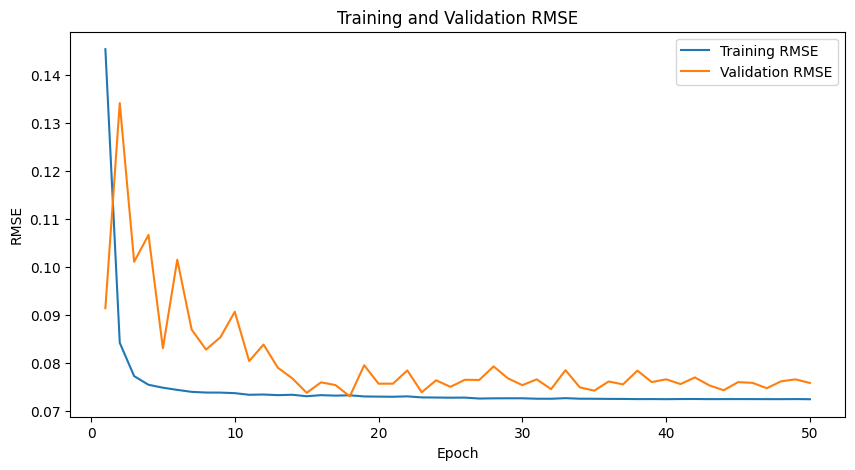

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training RMSE')
plt.plot(range(1, epochs + 1), val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

In [69]:
# Create a DataLoader for the test set with a smaller batch size
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64)  # Adjust batch size as needed

# Final evaluation on test set
GRU_model.eval()
test_loss_total = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        test_outputs = GRU_model(X_batch)
        test_loss = criterion(test_outputs, y_batch)  # MSE Loss
        test_loss_total += test_loss.item() * X_batch.size(0)  # Sum up the batch loss (weighted by batch size)

# Calculate the average loss and take the square root for RMSE
average_test_mse = test_loss_total / len(test_loader.dataset)
average_test_rmse = torch.sqrt(torch.tensor(average_test_mse)).item()
print(f"Final Test RMSE: {average_test_rmse:.4f}")

/home/scarlett/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([64, 1, 1, 1, 1, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Final Test RMSE: 0.0757


/home/scarlett/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([50, 1, 1, 1, 1, 1, 1])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


#### LSTM

In [70]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
LSTM_model = GeneLSTM(input_features=len(feature_columns)).to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.01)  # Corrected model reference
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
epochs = 50
for epoch in range(epochs):
    LSTM_model.train()
    train_loss_epoch = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = LSTM_model(X_batch)  # Corrected model reference
        train_mse_loss = criterion(outputs, y_batch)  # MSE Loss
        
        # Backward pass
        train_mse_loss.backward()
        torch.nn.utils.clip_grad_norm_(LSTM_model.parameters(), max_norm=1.0)  # Corrected model reference
        optimizer.step()
        
        train_loss_epoch += train_mse_loss.item()  # Accumulate MSE loss
    
    # Validation
    LSTM_model.eval()
    val_loss_epoch = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            val_outputs = LSTM_model(X_val_batch)  # Corrected model reference
            val_mse_loss = criterion(val_outputs, y_val_batch)
            val_loss_epoch += val_mse_loss.item()  # Accumulate MSE loss

    # Calculate average RMSE for the epoch
    avg_train_rmse = torch.sqrt(torch.tensor(train_loss_epoch / len(train_loader))).item()
    avg_val_rmse = torch.sqrt(torch.tensor(val_loss_epoch / len(val_loader))).item()

    # Store the RMSE losses for each epoch
    train_losses.append(avg_train_rmse)
    val_losses.append(avg_val_rmse)
    
    # Step the scheduler based on validation loss
    scheduler.step(val_loss_epoch / len(val_loader))  # Scheduler works with validation MSE

    print(f"Epoch [{epoch+1}/{epochs}], Train RMSE: {avg_train_rmse:.4f}, Validation RMSE: {avg_val_rmse:.4f}")

/home/scarlett/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/scarlett/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128, 1, 1, 1, 1, 1, 1])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/scarlett/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([111, 1, 1, 1, 1, 1, 1])) that is different to the input size (torch.Size([111, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/scarlett/.local/lib/python3.10/site-pa

Epoch [1/50], Train RMSE: 0.6612, Validation RMSE: 1.0784
Epoch [2/50], Train RMSE: 0.6590, Validation RMSE: 1.0705
Epoch [3/50], Train RMSE: 0.6615, Validation RMSE: 1.0728
Epoch [4/50], Train RMSE: 0.6601, Validation RMSE: 1.0780
Epoch [5/50], Train RMSE: 0.6602, Validation RMSE: 1.0864
Epoch [6/50], Train RMSE: 0.6600, Validation RMSE: 1.0781
Epoch [7/50], Train RMSE: 0.6603, Validation RMSE: 1.0792
Epoch [8/50], Train RMSE: 0.6592, Validation RMSE: 1.0696
Epoch [9/50], Train RMSE: 0.6597, Validation RMSE: 1.0726
Epoch [10/50], Train RMSE: 0.6615, Validation RMSE: 1.0766
Epoch [11/50], Train RMSE: 0.6591, Validation RMSE: 1.0686
Epoch [12/50], Train RMSE: 0.6619, Validation RMSE: 1.0893
Epoch [13/50], Train RMSE: 0.6607, Validation RMSE: 1.0696
Epoch [14/50], Train RMSE: 0.6607, Validation RMSE: 1.0831
Epoch [15/50], Train RMSE: 0.6615, Validation RMSE: 1.0905
Epoch [16/50], Train RMSE: 0.6595, Validation RMSE: 1.0549
Epoch [17/50], Train RMSE: 0.6613, Validation RMSE: 1.0812
Epoch 

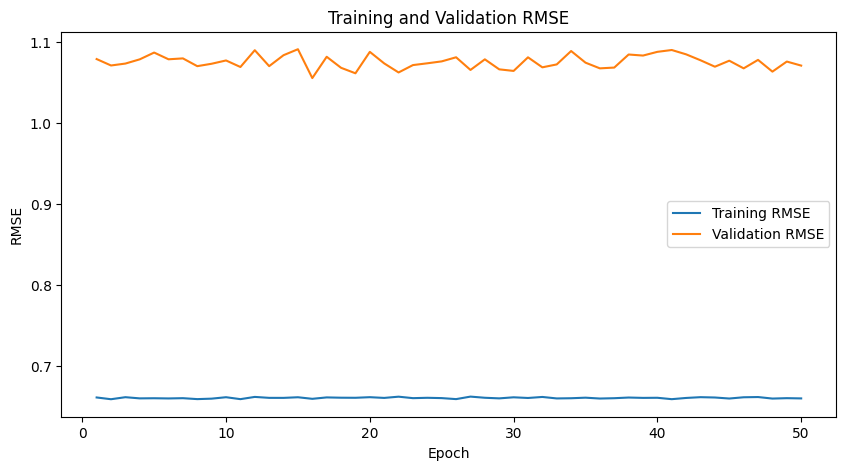

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training RMSE')
plt.plot(range(1, epochs + 1), val_losses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()

In [72]:
# Create a DataLoader for the test set with a smaller batch size
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64)  # Adjust batch size as needed

# Final evaluation on test set
LSTM_model.eval()
test_loss_total = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        test_outputs = LSTM_model(X_batch)
        test_loss = criterion(test_outputs, y_batch)  # MSE Loss
        test_loss_total += test_loss.item() * X_batch.size(0)  # Sum up the batch loss (weighted by batch size)

# Calculate the average loss and take the square root for RMSE
average_test_mse = test_loss_total / len(test_loader.dataset)
average_test_rmse = torch.sqrt(torch.tensor(average_test_mse)).item()
print(f"Final Test RMSE: {average_test_rmse:.4f}")

Final Test RMSE: 1.0704
